# Hypersurface
* In this notebook we perform spatial analysis using DBSCAN
* Generate (x,y) coordinates from the given (lat,long) coordinates using Mercator projection
  * The rationale behind using this potentially distortion-inducing transform is that the target area is small (a section of LA county) and so distortion will be negligible
* Generate clusters using DBSCAN on the 3D data vectors: (x, y, logerror)
* Analyze cluster statistics vs. global statistics
* Learn classifiers to learn cluster label based on features

In [1]:
# Expand IPython cell width to fit more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [9]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
# Enable grid by default
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
plt.style.use('seaborn')

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise

def print_full(x):
    with pd.option_context('display.max_rows', None, 'display.max_columns', 10, 'display.width', 400):
        print(x)

In [3]:
dftrain = pd.read_csv('train_2016_v2.csv')
dfprop = pd.read_csv('properties_2016.csv')

/Users/jlas/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
dftrain['transactiondate'] = pd.to_datetime(dftrain.transactiondate)

## Feature engineering
* Generated normalized and log-normalized features
* Generate boolean features e.g. single family, mult family, condo

In [6]:
df = pd.merge(dftrain, dfprop, on='parcelid', suffixes=('', '_r'))

In [11]:
def norm(y):
    ymin = y.min()
    return (y - ymin) / (y.max() - ymin)

def lognorm(y):
    y = np.log(y.fillna(y.mean()))
    return norm(y)

def preprocess(_df):
    for newc, oldc in [
        ('sqft', 'calculatedfinishedsquarefeet'),
        ('finish12_sqft', 'finishedsquarefeet12'),
        ('lot_sqft', 'lotsizesquarefeet'),
        ('taxamt', 'taxamount'),
        ('taxval', 'taxvaluedollarcnt'),
        ('structure_tax', 'structuretaxvaluedollarcnt'),
        ('land_tax', 'landtaxvaluedollarcnt')
    ]:
        _df[newc] = lognorm(_df[oldc])

    _df['year'] = norm(_df.yearbuilt.fillna(_df.yearbuilt.median()).astype('int'))
    _df['quality'] = norm(-_df.buildingqualitytypeid.fillna(_df.buildingqualitytypeid.mean()).astype('int'))

    _df['single_fam'] = _df.propertylandusetypeid==261
    _df['multi_fam'] = _df.propertylandusetypeid.isin([246, 247, 248])
    _df['condo'] = _df.propertylandusetypeid==266    

    return _df

## Use Mercator projection to map (lat, long) to (x, y)

In [5]:
# https://stackoverflow.com/a/14457180
mapWidth = 5
mapHeight = 5
dfprop['lat_scaled'] = dfprop.latitude / 1e6
dfprop['long_scaled'] = dfprop.longitude / 1e6
dfprop['x'] = (dfprop.long_scaled+180.)*(mapWidth/360.)
latRad = (dfprop.lat_scaled*np.pi/180.)
mercN = np.log(np.tan((np.pi/4.)+(latRad/2.)))
dfprop['y'] = (mapHeight/2.)-(mapWidth*mercN/(2.*np.pi))

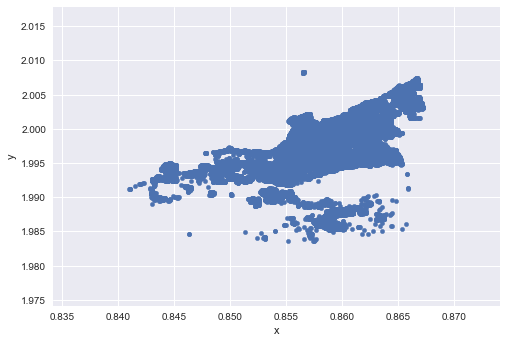

In [10]:
df.plot.scatter('x','y')

In [26]:
def dbscan(data, eps=0.001, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(data[['x','y', 'logerror']])
    labels = pd.Series(db.labels_)
    data = data.reset_index().rename(columns={'index': 'oindex'})
    data['label'] = labels
    return data

def plot_dbscan(data, collapse=False):
    print('unique labels:', len(data.label.unique()))
    print('total data points:', len(data))
    print('noise:', (data.label==-1).sum())
    print('top labels:\n', data.label.value_counts().head())

    fig = plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')
    cm = plt.cm.get_cmap('prism')
    maxlabel = data.label.max()
    if collapse:
        data = data.groupby('label').mean().reset_index()
    ax.scatter(
        data.x, data.y, data.logerror,
        color=data.label.apply(lambda l: 'black' if l==-1 else cm(l / maxlabel)))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('logerror')

In [13]:
df[['x','y']].describe()

,x,y
count,90275.000000,90275.000000
mean,0.858349,1.997245
std,0.005008,0.004441
min,0.841002,1.983605
25%,0.855393,1.994446
50%,0.858702,1.996982
75%,0.862200,2.000496
max,0.867293,2.008369


## Generate the hypersurface
* The hypersurface name comes from the idea that points lie on the x, y plane but are distinct from other planes by the third dimension, logerror

unique labels: 1109
total data points: 84501
noise: 11686
top labels:
 -1     11686
 1     11431
 8      2150
 58     2133
 24     1986
Name: label, dtype: int64


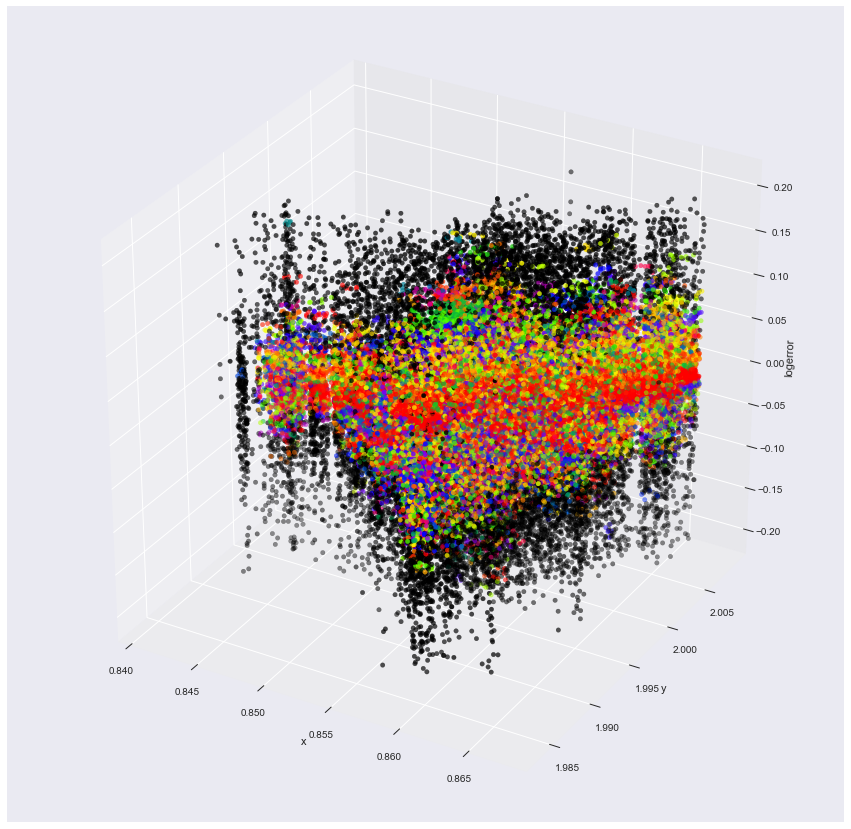

In [44]:
# Truncate the logerror to a constrained slice
tmpdf = df[(-.2<df.logerror)&(df.logerror<0.2)].copy()

tmpdf = preprocess(tmpdf)
tmpdf = dbscan(tmpdf, 0.001)
plot_dbscan(tmpdf)

## Zoom in

unique labels: 199
total data points: 6708
noise: 846
top labels:
 -1     846
 21    164
 35    149
 19    148
 22    142
Name: label, dtype: int64


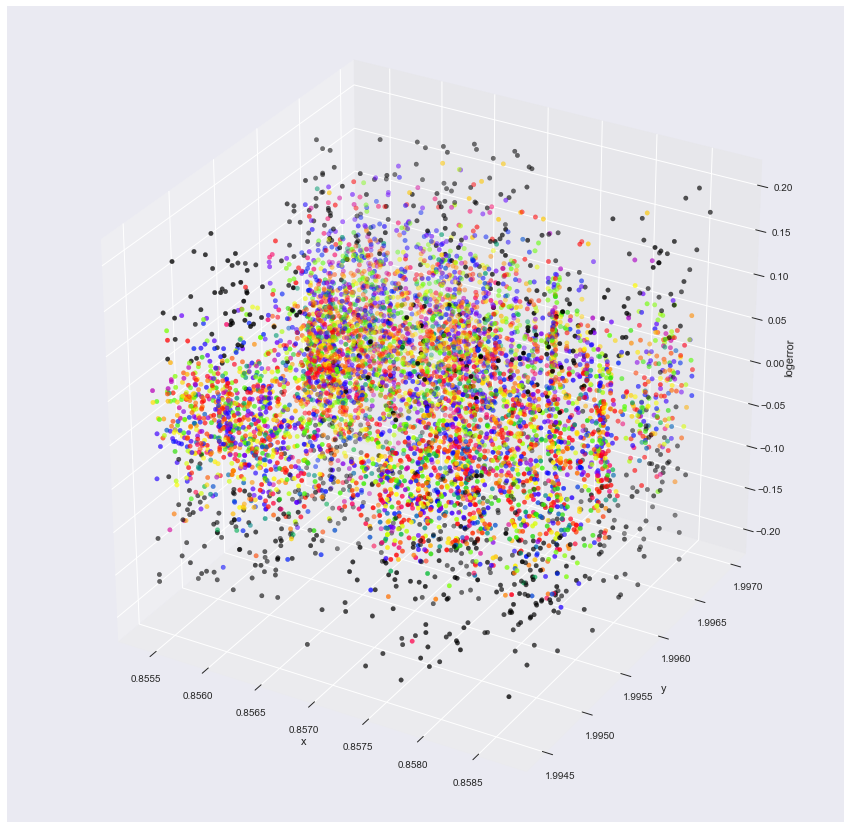

In [53]:
xmin = 0.855393
xmax = 0.858702
ymin = 1.994446
ymax = 1.996982

tmpdf = df[(xmin<df.x)&(df.x<xmax)&\
           (ymin<df.y)&(df.y<ymax)&\
           (-.2<df.logerror)&(df.logerror<0.2)].copy()

tmpdf = preprocess(tmpdf)
tmpdf = dbscan(tmpdf)
plot_dbscan(tmpdf)

## Global vs local statistics
* Visualize feature statistics of cluster vs. global
* Some features show better filtering capabilities when clustered

In [15]:
def gvl(_df):
    """
    Print global vs local statistics as DataFrame, side by side
    """
    gdf = _df.describe().T[['mean','std','min','max']]
    gdf = gdf.rename(columns={c:'g'+c for c in gdf})

    for k, v in _df.label.value_counts().head().iteritems():
        if k == -1:
            continue
        print(k)
        ldf = _df[_df.label==k].describe().T[['mean','std','min','max']]
        print_full(pd.concat([gdf, ldf], axis=1))

In [33]:
def gvl_hist(_df, cols):
    """
    Create side by side global vs local histograms
    """
    ncols = 2
    nrows = (2*len(cols) + ncols - 1) / ncols
    for k, v in _df.label.value_counts().head().iteritems():
        if k == -1:  # No cluster
            continue
        print("cluster", k)
        fig = plt.figure(figsize=(18, nrows*5))
        idx = 1
        for c in cols:
            ax = plt.subplot(nrows, ncols, idx)
            _df[c].hist(bins=100, ax=ax)
            ax.set_xlabel(c)
            ax = plt.subplot(nrows, ncols, idx+1)
            _df[_df.label==k][c].hist(bins=100, ax=ax)
            ax.set_xlabel(c)
            idx += 2
        plt.show()

cluster 1


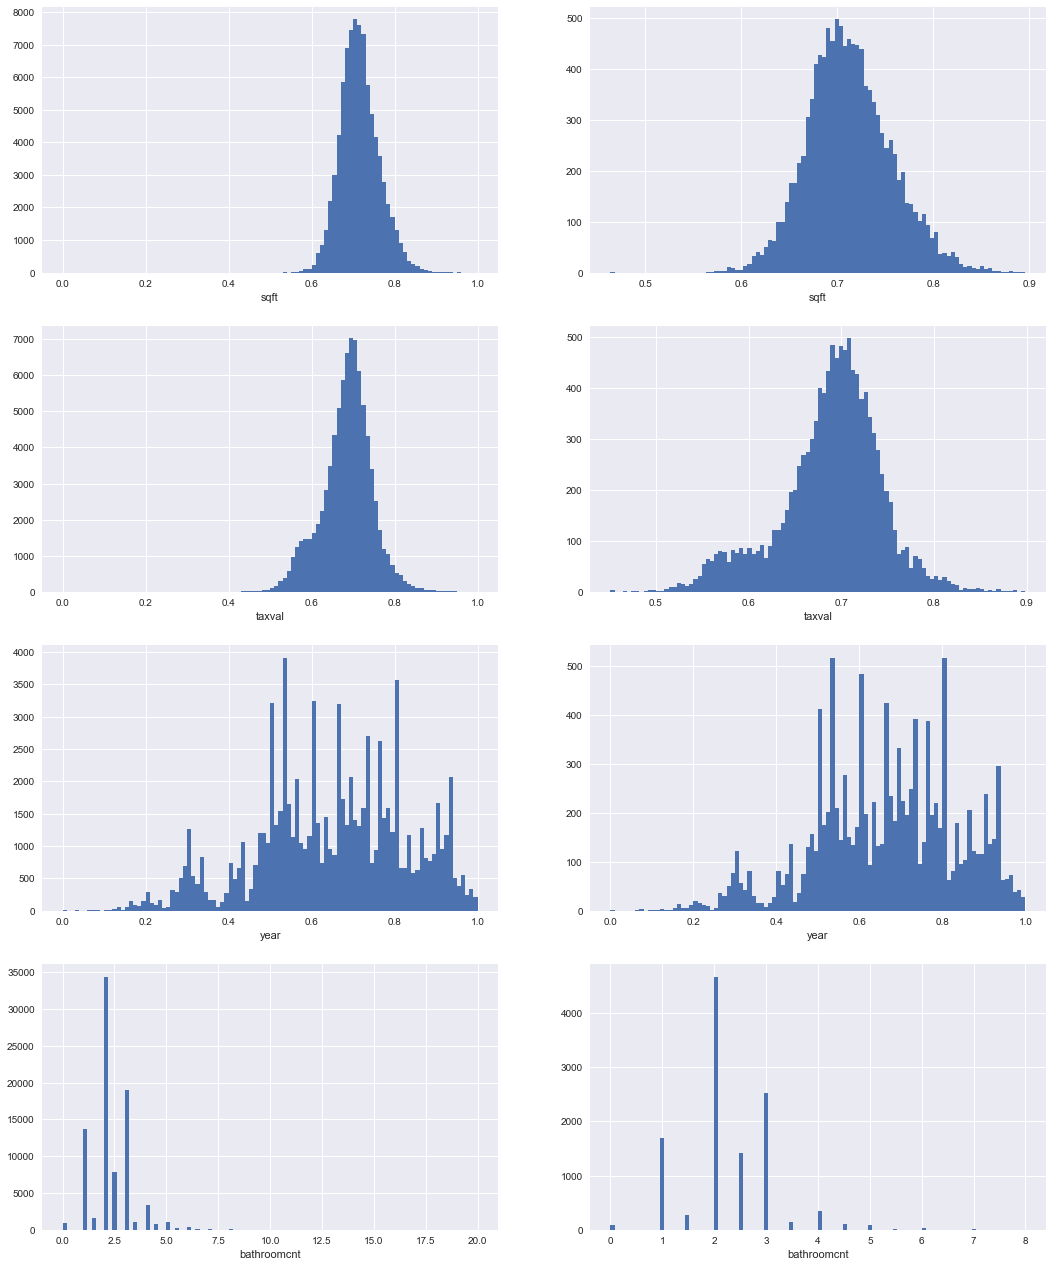

cluster 8


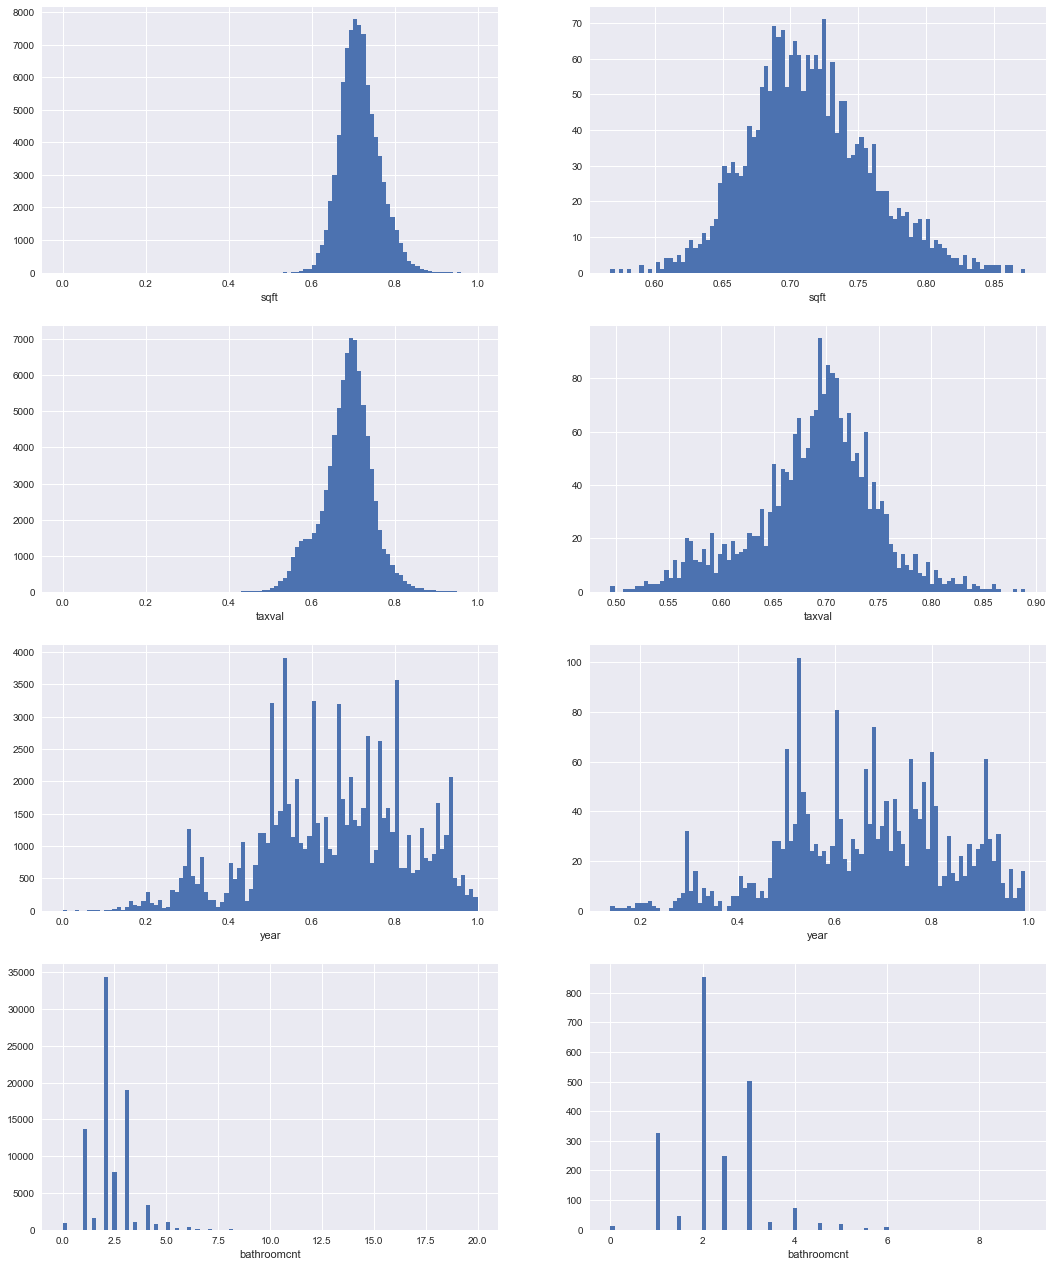

cluster 58


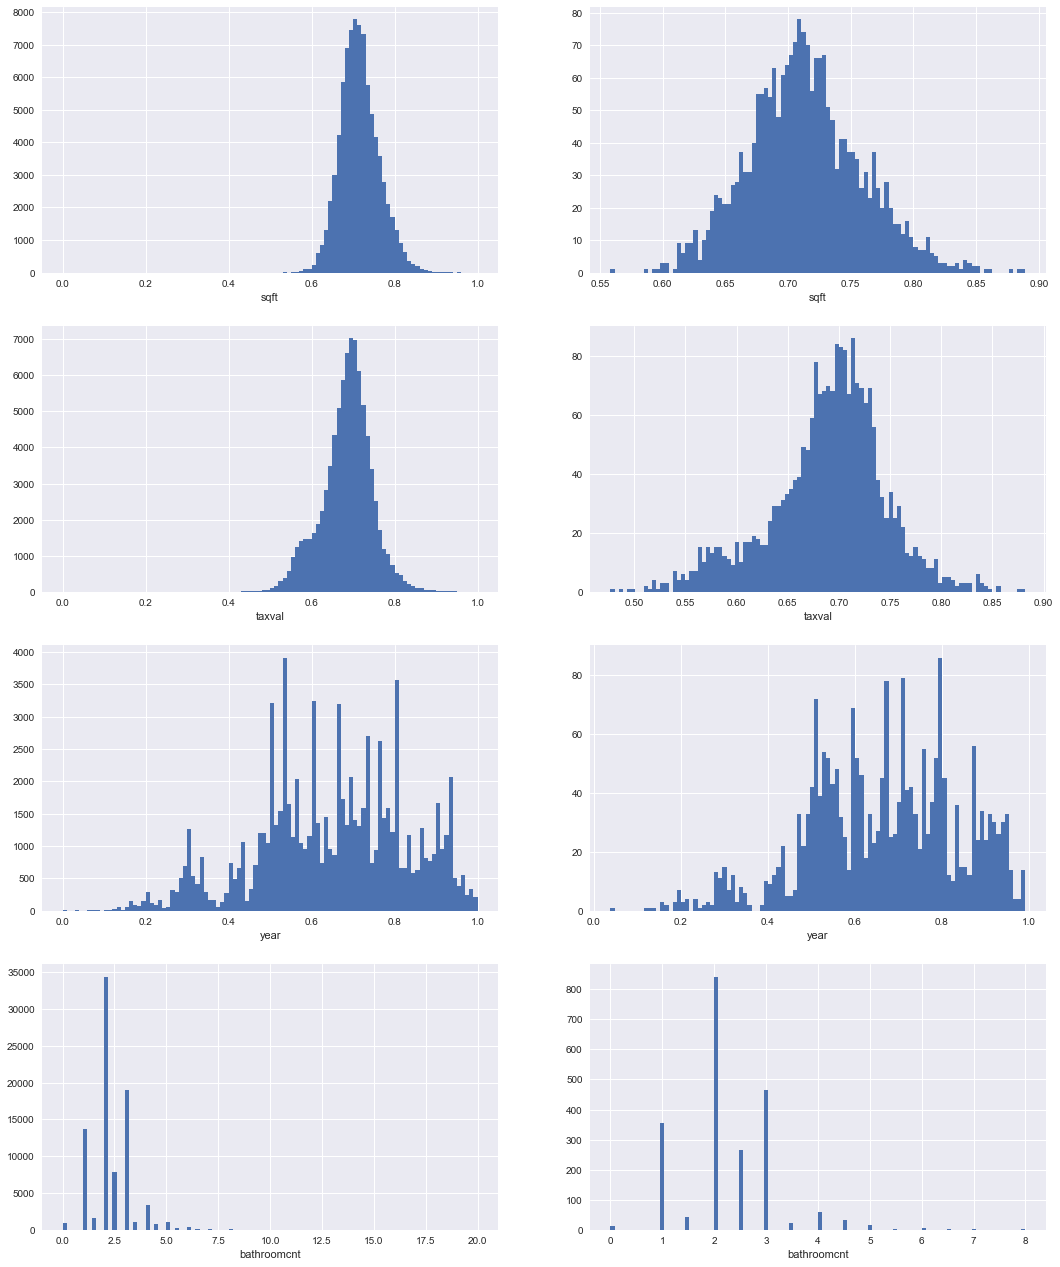

cluster 24


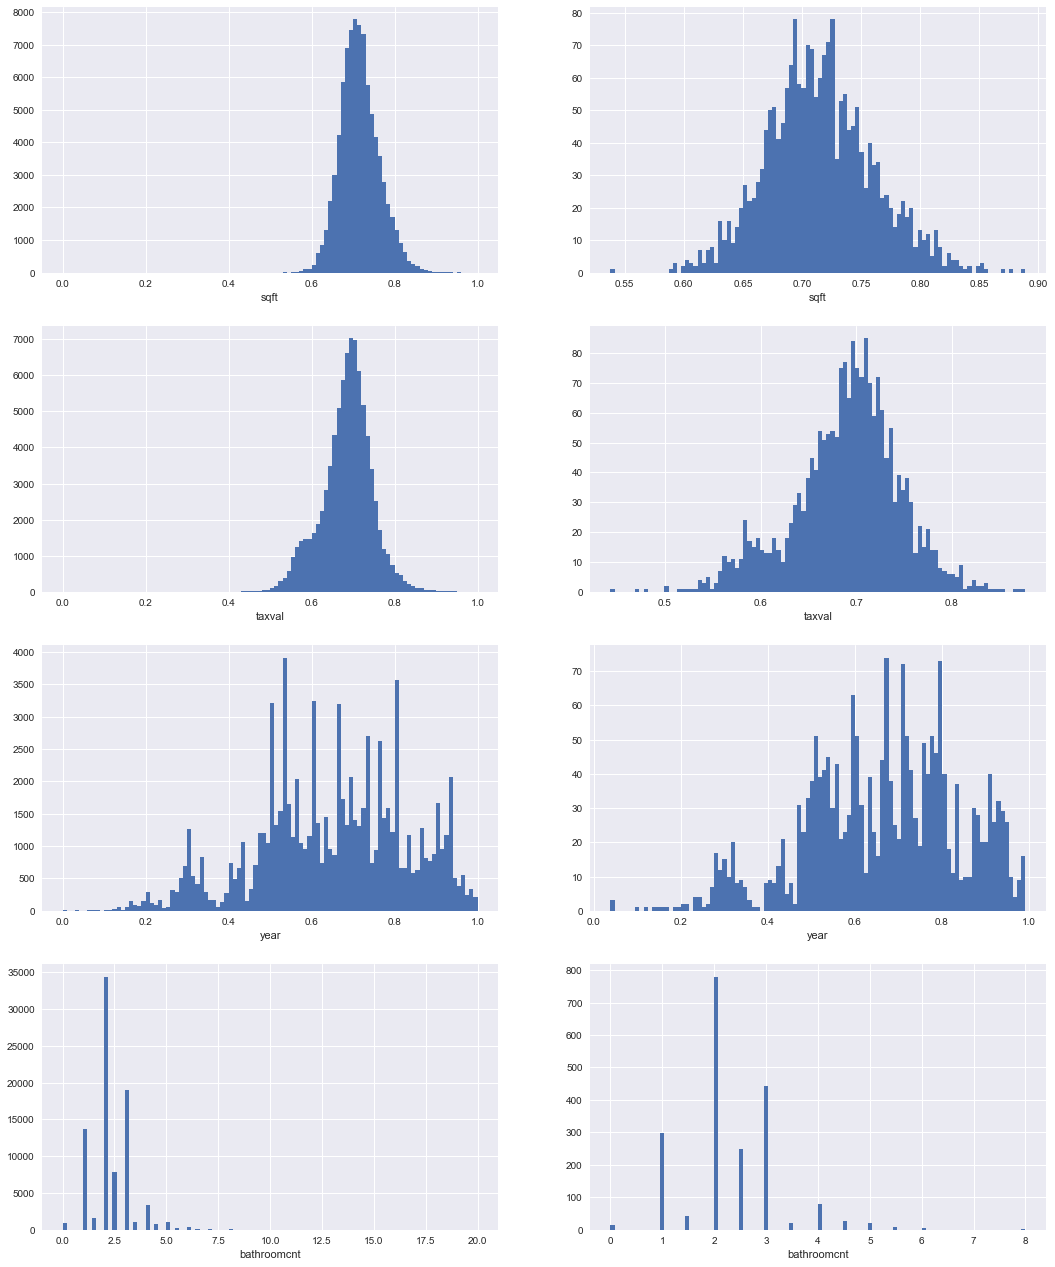

In [36]:
gvl_hist(tmpdf, ['sqft', 'taxval', 'year', 'bathroomcnt'])

## Per cluster statistics
* Visualize median feature statistic vs. logerror per cluster

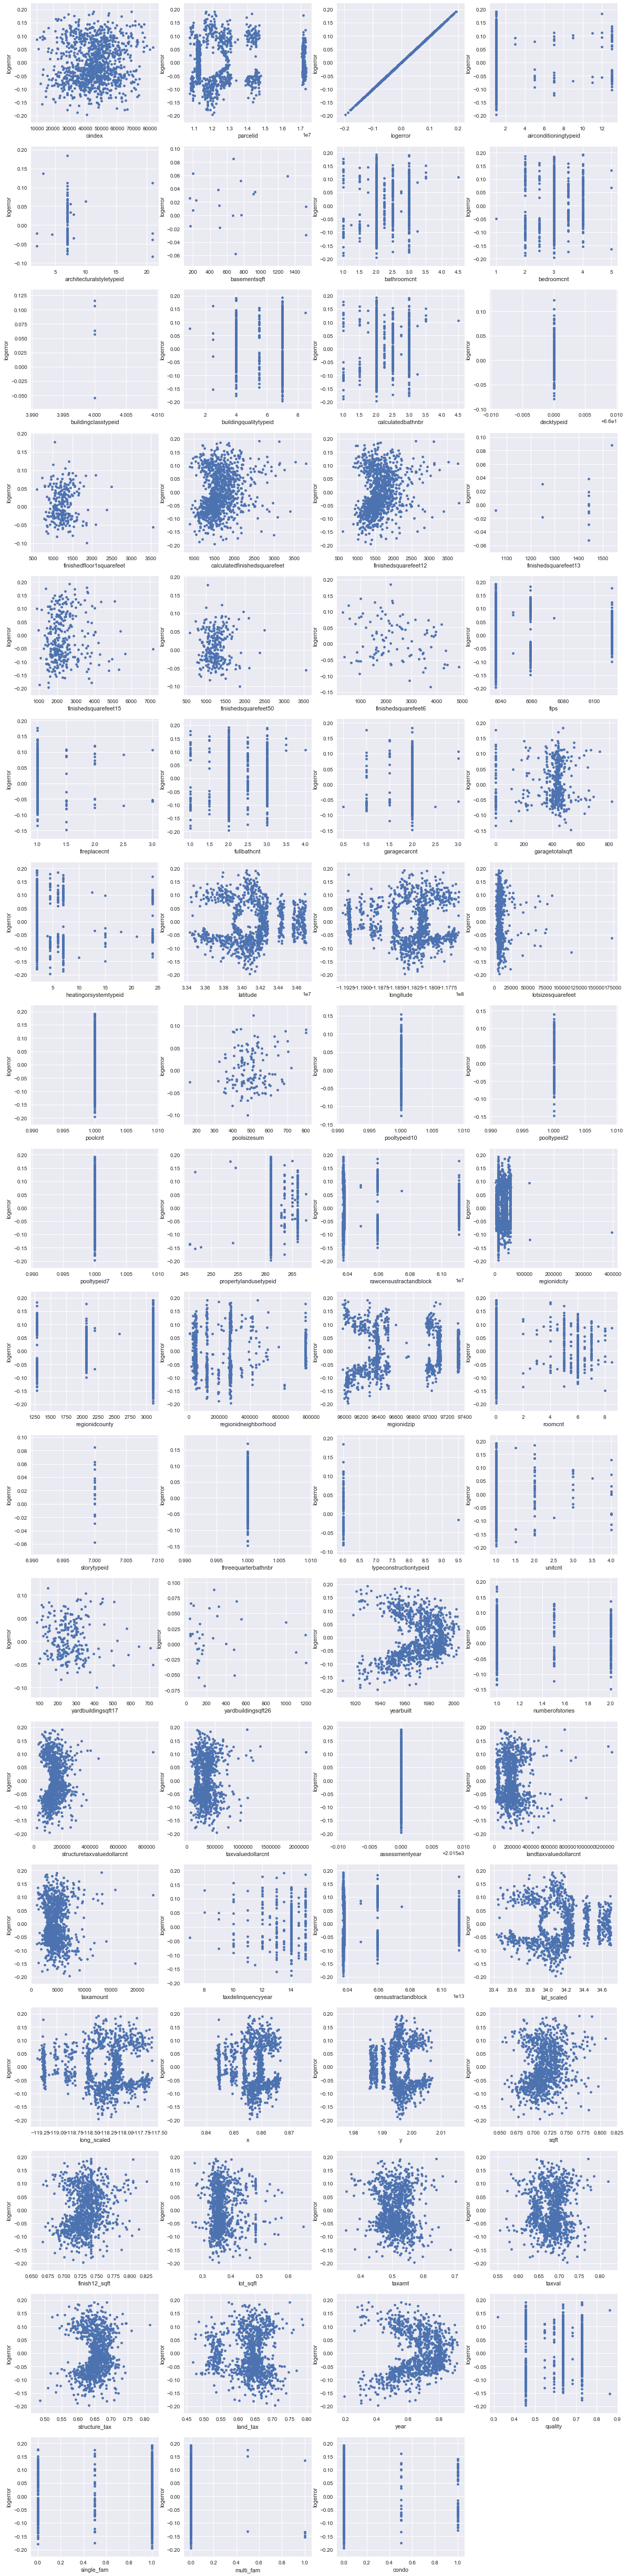

In [37]:
def per_cluster(_df):
    """
    Groupby cluster label and apply median aggregation to each feature
    """
    _df2 = _df[_df.label!=-1].groupby('label').median()
    ncols = 4
    nrows = len(_df2.columns)
    fig = plt.figure(figsize=(20, nrows*5))
    idx = 1
    for c in _df2.columns:
        ax = plt.subplot(nrows, ncols, idx)
        _df2.plot.scatter(x=c, y='logerror', ax=ax)
        ax.set_xlabel(c)
        idx += 1
    plt.show()

per_cluster(tmpdf)

In [38]:
def lcl_logerr(_df):
    s = _df.groupby('label').logerror
    mean = s.mean()
    mean.name = 'mean'
    std = s.std()
    std.name = 'std'
    return pd.concat([mean, std], axis=1)

lcl_logerr(tmpdf)

,mean,std
label,,
-1,-0.001553,0.119741
0,0.027600,0.000000
1,0.000203,0.004303
2,0.022717,0.000781
3,0.043564,0.000450
4,0.034400,0.000000
5,0.082633,0.001125
6,-0.044493,0.000500
7,-0.041900,0.000000


## Count # of nulls per feature in a subset of clusters

In [39]:
def null_features(_df, labels):
    nticks = len(labels)*len(_df.columns)
    fig = plt.figure(figsize=(15,40))
    ax = plt.subplot(111)
    for i, l in enumerate(labels):
        pdf = _df
        if not l is None:
            pdf = _df[_df.label==l]
        merr = pdf.logerror.mean()
        label = '{}, mean_logerr: {:.4f}'.format(l, merr)
        pdf = (pdf.isnull().sum() / len(pdf)).sort_index()
        pdf /= len(pdf)
        ax.barh(range(i, nticks, len(labels)), pdf.values, tick_label=pdf.index, label=label)
    ax.invert_yaxis()
    plt.ylim([-1, nticks+1])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()
    plt.show()

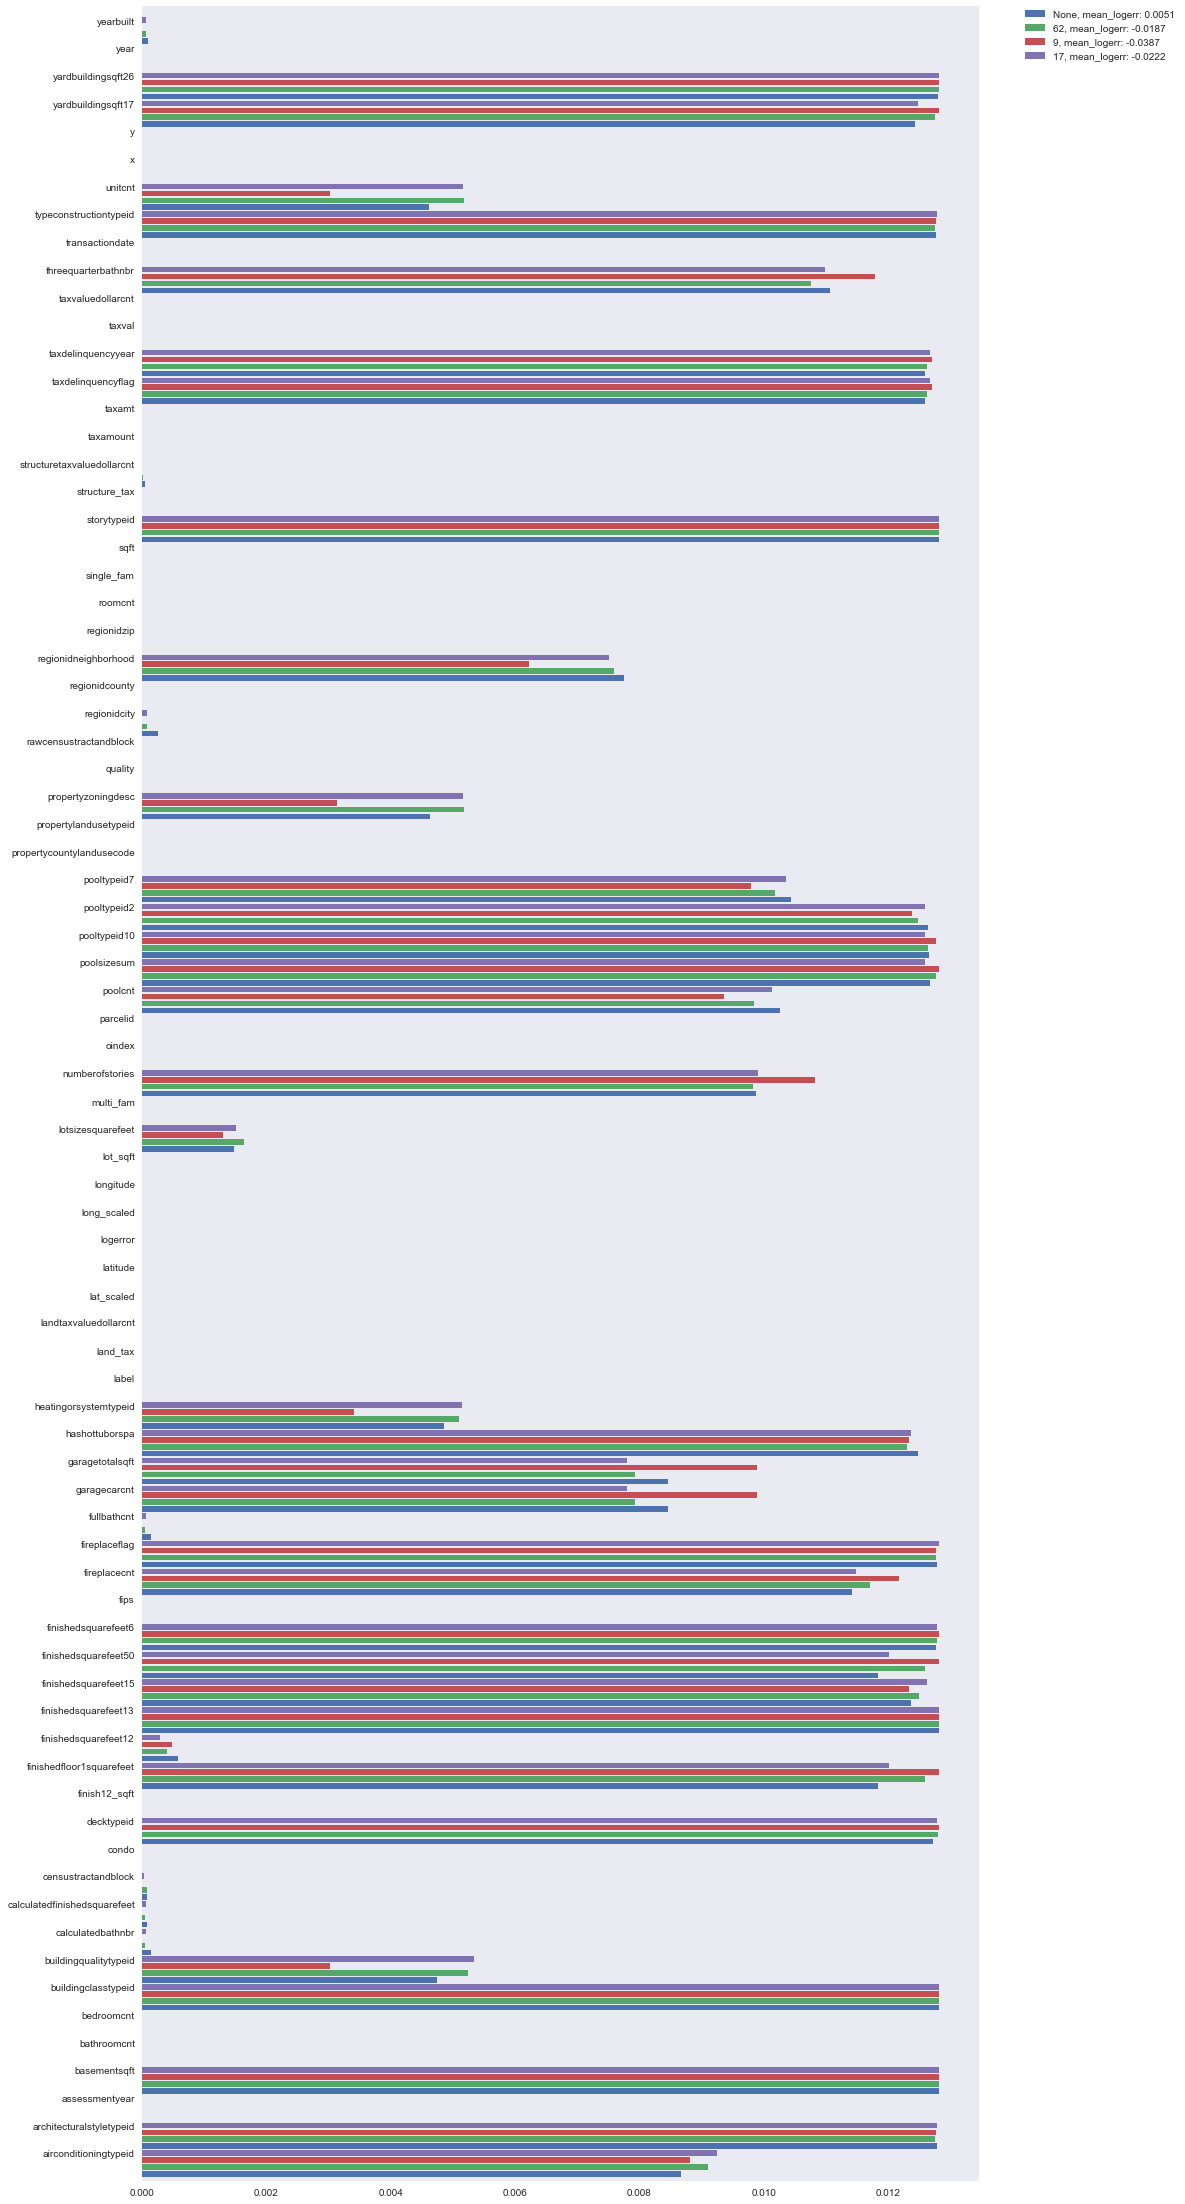

In [40]:
null_features(tmpdf, [None, 62, 9, 17])

## Gridify
* Break up total data space along x, y axis into grids
* Apply hypersurface clustering individually on each grid

In [ ]:
def getgridcellfn(minx, miny, cellsz):
    def getgridcell(x, y):
        xidx = (x - minx) / cellsz
        yidx = (y - miny) / cellsz
        return int(xidx), int(yidx)
    return getgridcell

def gridify(_df, ngrids=20, eps=0.001, min_samples=5, _print=False):
    """
    Break up data into grids by x, y coordinates
    """
    grid = []
    cellsz = max(_df.x.max() - _df.x.min(), _df.y.max() - _df.y.min())*1.01 / ngrids
    x = _df.x.min()
    labelcnts = []
    while x < _df.x.max():
        grid.append([])
        y = _df.y.min()
        while y < _df.y.max():
            _df2 = _df[(x<=_df.x)&(_df.x<x+cellsz)&(y<=_df.y)&(_df.y<y+cellsz)]
            if len(_df2) == 0:
                _df2['label'] = -1
                grid[-1].append(None)
            else:
                _df2 = dbscan(_df2.copy(), eps=eps, min_samples=min_samples)
                grid[-1].append(_df2)
            nlabels = len(_df2.label.unique())
            labelcnts.append(nlabels)
            if _print: print("{:-5}".format(nlabels), end=' ')
            y += cellsz
        if _print: print()
        x += cellsz

    labelcnts = list(filter(lambda g: g>0, labelcnts))
    print('Average labels per cell: {}'.format(sum(labelcnts)/len(labelcnts)))

    meta = {
        'grid': grid,
        'cellsz': cellsz,
        'getgridcell': getgridcellfn(_df.x.min(), _df.y.min(), cellsz)
    }
    return meta

In [56]:
def test_gridify(_df):
    """
    Test the gridify function
    """
    meta = gridify(_df, 20)
    for i in range(len(_df)):
        testrec = _df.iloc[i]
        cellidx = meta['getgridcell'](testrec.x, testrec.y)
        _df2 = meta['grid'][cellidx[0]][cellidx[1]][['x','y']]
        assert (_df2.x.min() <= testrec.x) and (testrec.x <= _df2.x.max())
        assert (_df2.y.min() <= testrec.y) and (testrec.y <= _df2.y.max())

test_gridify(tmpdf)

Average labels per cell: 1.0136054421768708


## Train XGBoost classifier to learn the cluster label

In [11]:
tmpdf = df[(-.2<df.logerror)&(df.logerror<0.2)].copy()
tmpdf = preprocess(tmpdf)
meta = gridify(tmpdf, 50, eps=0.0025, min_samples=4, _print=False)

Average labels per cell: 6.01115760111576


In [12]:
from xgboost import XGBClassifier
from sklearn import cross_validation

clf = XGBClassifier(objective='multi:softmax', nthread=4, n_estimators=50, max_depth=4)
data = meta['grid'][25][25]
data = data[data.label!=-1]
X = data.drop([
    'parcelid', 'logerror', 'oindex', 'label', 'transactiondate',
    'hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc',
    'fireplaceflag', 'taxdelinquencyflag'], axis=1)

scores = cross_validation.cross_val_score(
    clf, X, data.label, cv=2, scoring='accuracy')
print("%s Accuracy: %0.5f (+/- %0.5f)" % (clf.__class__.__name__, scores.mean(), scores.std() * 2))

/Users/jlas/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGBClassifier Accuracy: 0.17382 (+/- 0.03438)


In [13]:
data.columns

Index(['oindex', 'parcelid', 'logerror', 'transactiondate',
       'airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
    

unique labels: 15
total data points: 216
noise: 44
top labels:
  1    44
-1    44
 4    24
 2    18
 0    16
Name: label, dtype: int64


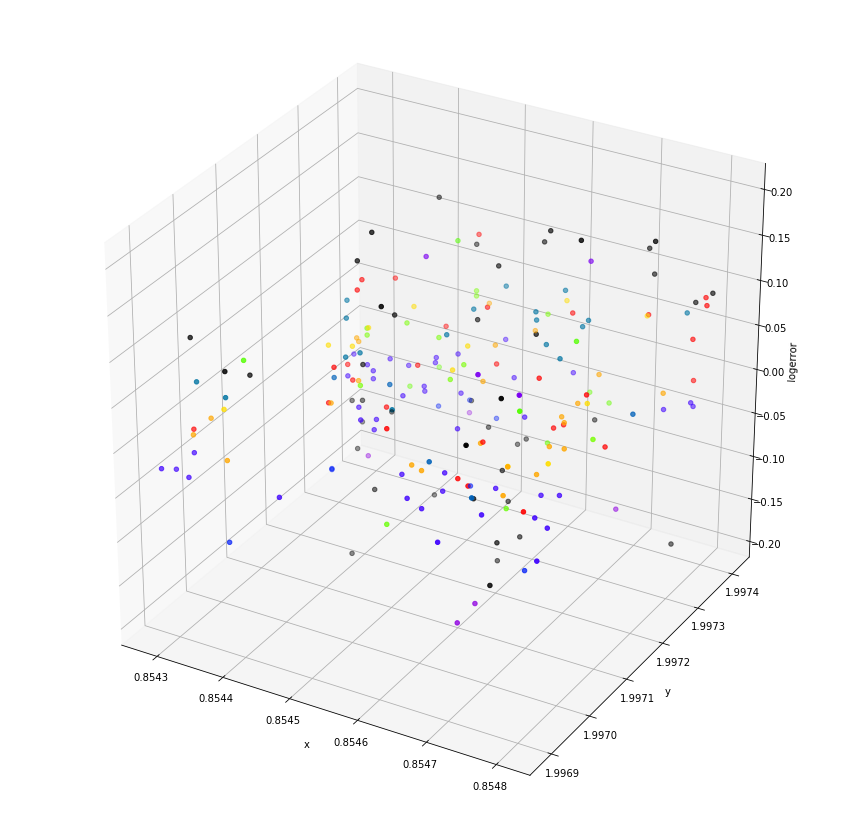

In [173]:
plot_dbscan(meta['grid'][25][25])

# Distance metrics

In [57]:
dfeat = [
    'lot_sqft',
    'finish12_sqft',
    'sqft',
    'taxval',
    'taxamt',
    'single_fam',
    'multi_fam',
    'condo',
    'quality',
    'year'
]

neigh = NearestNeighbors()
neigh.fit(tmpdf[['x', 'y']])

def distfn(data, point):
    # Find nearest neighbors by x, y
    dist, idx = neigh.kneighbors(point[['x', 'y']].to_frame().T, n_neighbors=5)
    # Get records corresponding to neighbors' clusters
    superset = data[data.label.isin(data.loc[idx[0]].label)].copy()
    # Calculate distance to each and aggregate
    superset['dist'] = pairwise.euclidean_distances(superset[dfeat], point[dfeat].to_frame().T)
    return superset.groupby('label').dist.median()

In [60]:
def test(data):
    """
    Count the number of data points whose closest neighbor has their same label
    """
    cnt = 0
    for idx, point in data.iterrows():
        if point.label == -1:  # No cluster
            continue
        r = distfn(data, point)
        if point.label == r.sort_values().index[0]:
            cnt += 1
    return cnt

In [59]:
print(test(tmpdf) / len(tmpdf))

0.17978533094812166
